In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- try14랑 똑같은데
- 타겟값 log scaling은 빼기

In [14]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# font_path = "C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
from sklearn.manifold import TSNE
import re
import talib as tb

In [17]:
def weather(주소,name = 'train'):
    t=0
    if name =='test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        globals()[f'{name}_weather_'+str(i)]=pd.DataFrame()

        for k in range(0,3):
            try:
                weather = pd.read_csv(주소+f'/weather_{i}_{t}.csv')
                if len(weather)==0:
                    weather = pd.read_csv(주소+f'/weather_0_0.csv')
                    weather=weather.set_index('datadate')
                    weather[weather.columns] = 0
                    weather=weather.reset_index()
                weather = weather.set_index('datadate')
                weather['습도(%)']=weather['습도(%)'].apply(lambda x : np.nan if x==' ' else x)
                weather['습도(%)']=weather['습도(%)'].astype('float')
                weather.columns = weather.columns+f'_{k%3}'
                globals()[f'{name}_weather_'+str(i)]=pd.merge(globals()[f'{name}_weather_'+str(i)],weather,how='right',left_index=True, right_index=True)    


            except:
                break
            t+=1



        globals()[f'{name}_weather_'+str(i)]=globals()[f'{name}_weather_'+str(i)].reset_index()
        cols = globals()[f'{name}_weather_'+str(i)].columns
        globals()[f'{name}_weather_'+str(i)]['월일']=globals()[f'{name}_weather_'+str(i)]['datadate']%10000
       

        
        if name == 'train':
            qwe =  globals()[f'{name}_weather_'+str(i)].groupby('월일').mean().reset_index()
            qwe.columns = qwe.columns+'_평균'
            globals()[f'train_weather_평균_'+str(i)]= qwe



            


        globals()[f'{name}_weather_'+str(i)] = pd.merge(globals()[f'{name}_weather_'+str(i)],globals()[f'train_weather_평균_'+str(i)],how='left',left_on = '월일',right_on='월일_평균')
        for c in cols:
            globals()[f'{name}_weather_'+str(i)][c]=globals()[f'{name}_weather_'+str(i)].apply(lambda x: x[c] if np.isnan(x[c]) == False else (0 if np.isnan(x[c+'_평균']) else x[c+'_평균']),axis=1)
                
    
        
        
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        else:
            globals()[f'{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        

In [18]:
def add_dosomae(주소,name='train', option=1):
        if name == 'test':
            test_dir = 주소.split('/')[-2][-1]
        data_list = glob(주소+'*') # train raw 데이터 넣을지 / test raw 데이터 넣을지 경로
        domae = []
        somae = []

        for i in data_list:
            if 'domae' in i:
                domae.append(i)
            if 'somae' in i:
                somae.append(i)
        
        sum_df = pd.DataFrame()
                
        if option == 1:
            df = domae
            text = 'domae'
        else:
            df = somae
            text = 'somae'


        for i in tqdm(df):
            test = pd.read_csv(i)
            
            k=i.split('/')[-1].split("_")[1].split(".")[0]
            test.fillna(0,inplace=True) # 널값 0으로 채워주고
            if len(test)==0:
                test = pd.read_csv(주소+f'/domae_0.csv')
                test=test.set_index('datadate')
                test[test.columns] = 0
                test=test.reset_index()
                

            
            test['조사단위(kg)'] = test['조사단위(kg)'].replace('g$|kg$|개|포기|접', '',regex=True)
            test=test.astype({'조사단위(kg)':'float'})
            test.loc[test['조사단위(kg)'] >= 100, '단위당가격'] = test['가격(원)']* test['조사단위(kg)'] /1000
            test.loc[test['조사단위(kg)'] < 100, '단위당가격'] = test['가격(원)']/ test['조사단위(kg)']
            
            sep = test.loc[(test['등급명'] == '상품') | (test['등급명'] == 'S과') | (test['등급명'] == 0)]   # 모든 상품에 대해서 수행하지 않고 GRAD_NM이 '상품', 'S과' 만 해당하는 품목 가져옴
            sep = sep[['datadate', '등급명', '조사단위(kg)', '가격(원)']]

            sep.rename(columns={"가격(원)": "가격"}, inplace=True)
            sep2 = sqldf(
                f"select datadate, max(가격) as '일자별_{text}가격_최대(원)', avg(가격) as '일자별_{text}가격_평균(원)', min(가격) as '일자별_{text}가격_최소(원)' from sep group by datadate")

            sep2.fillna(0,inplace=True)
#             if len(sep2) == 0:
#                 if name=='test':
#                     sep2 =  globals()['sep_'+test_dir+f'_{name}_{text}_0'] 
#                     sep2

#                 else:
#                     sep2 =  globals()[f'{name}_{text}_0'] 
#                     sep2[sep2.columns] = 0 
                
                
            if name=='test':
                globals()['sep_'+test_dir+f'_{name}_{text}_{k}'] = sep2
                
            else:
                globals()[f'{name}_{text}_{k}'] = sep2
 
                


        
                               
               
             

In [19]:
def pummok(주소,name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):

        try:
            pummok = pd.read_csv(주소+f'/pummok_{i}.csv')
            if len(pummok) == 0 :
                pummok = pd.read_csv(주소+f'/pummok_0.csv')
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]
                pummok[pummok.columns] = 0
                pummok = pummok.reset_index()
                
            else:   
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]

                # 새로 추가한 부분
                pummok['해당일자_전체평균가격(원)'].fillna(0, inplace=True)
                pummok['wma14'] =  tb.WMA(pummok['해당일자_전체평균가격(원)'], 14)
                pummok['wma14'].fillna(method='bfill', inplace=True)

                # wma * 1.2 적용  -> 그림이 제일 비슷하게 나온다.
                pummok['해당일자_전체평균가격(원)'] = np.where(pummok['해당일자_전체평균가격(원)']==0, pummok['wma14']*1.2, pummok['해당일자_전체평균가격(원)'])
                pummok.drop('wma14', axis=1, inplace=True)


                
                pummok = pummok.reset_index()
                pummok.fillna(0, inplace = True)
                # pummok.fillna(0,inplace = True)
                
                
                

        except:
            continue

        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_pummok_{i}'] = pummok

        else:
            globals()[f'{name}_pummok_{i}'] = pummok


In [20]:
def imexport(주소, name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        try:
            imexport=pd.read_csv(주소+f'/imexport_{i}.csv')
            
            if len(imexport) == 0:
                imexport = pd.read_csv(주소+f'/imexport_0.csv')
                imexport = imexport.groupby('datadate').mean()
                imexport[imexport.columns] = 0

            else:  
                imexport = imexport.groupby('datadate').mean()


        except:
            
            imexport = pd.read_csv(주소+f'/imexport_0.csv')
            imexport = imexport.groupby('datadate').mean()
            imexport[imexport.columns] = 0
            pass


        imexport.fillna(0,inplace=True)
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_imexport_{i}'] = imexport

        else:
            globals()[f'{name}_imexport_{i}'] = imexport


    
    

In [21]:
def make_csv(주소,name = 'train'):
    imexport(주소,name)
    pummok(주소,name)
    add_dosomae(주소,name)
    add_dosomae(주소,name,2)
    weather(주소,name)
    for i in range(0,37):
        if name == 'test':

            num = 주소.split('/')[-2][-1]
            
            
            temp = globals()[f'sep_{num}_{name}_pummok_{i}']

            temp1 = globals()[f'sep_{num}_{name}_weather_{i}']

            temp2 = globals()[f'sep_{num}_{name}_domae_{i}']
   
            temp3 = globals()[f'sep_{num}_{name}_somae_{i}']

            temp4 = globals()[f'sep_{num}_{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)

            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_sep_{num}_{i}'] = temp


        else:
            temp = globals()[f'{name}_pummok_{i}']
            temp1 = globals()[f'{name}_weather_{i}']
            temp2 = globals()[f'{name}_domae_{i}']
            temp3 = globals()[f'{name}_somae_{i}']
            temp4 = globals()[f'{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)
            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_{i}'] = temp
        
    

In [22]:
# train_data만들기 train_total_0 ~ train_total_36까지 만들어준다.
make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_train_raw/','train')

100%|██████████| 37/37 [00:17<00:00,  2.10it/s]


In [23]:
def make_smoothing(df):
  df['해당일자_전체평균가격(원)'] = tb.WMA(df['해당일자_전체평균가격(원)'], 14)
  df.fillna(method='bfill', inplace=True)
  return df

In [24]:
# train_data smoothing 해주기~
for i in range(37):
  globals()[f'train_smoothing_{i}'] = make_smoothing(globals()[f'train_total_{i}'])

In [25]:
# nan이 생겼나 확인
for i in range(37):
  print(len(globals()[f'train_smoothing_{i}']), globals()[f'train_smoothing_{i}'].isna().sum().sum())

1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0


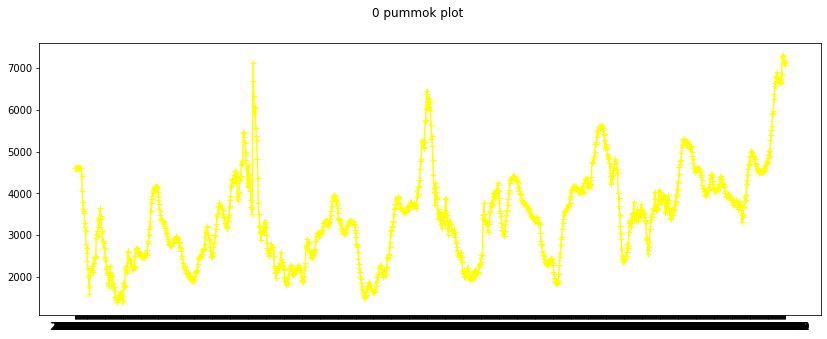

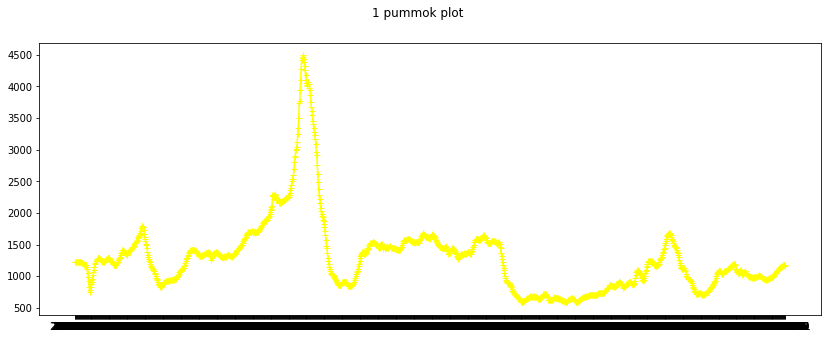

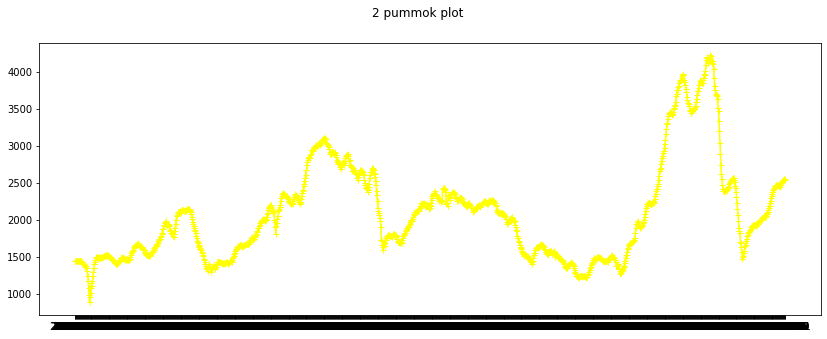

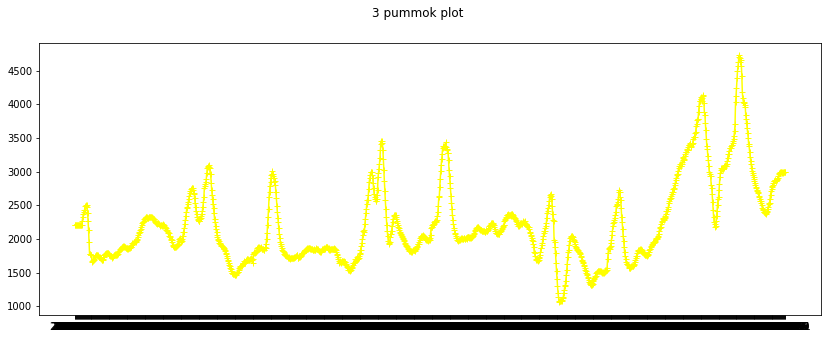

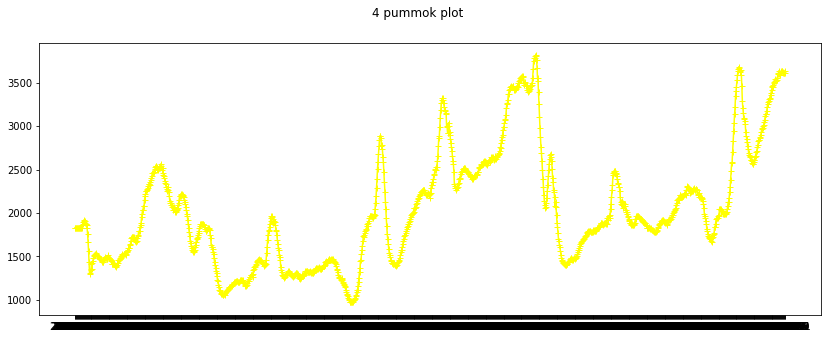

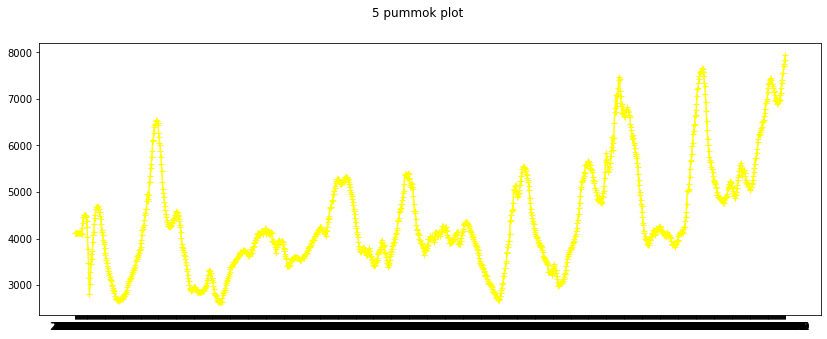

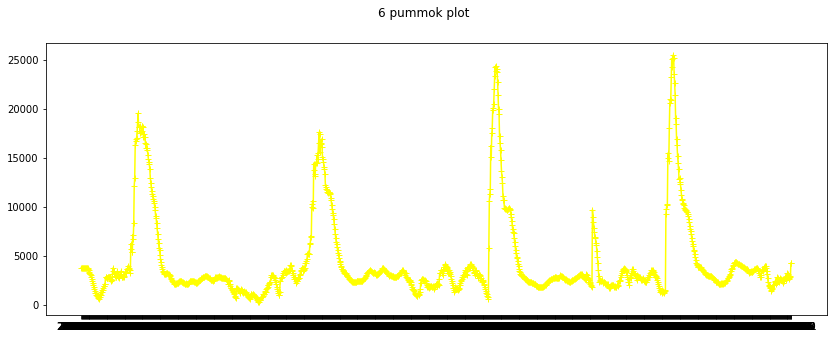

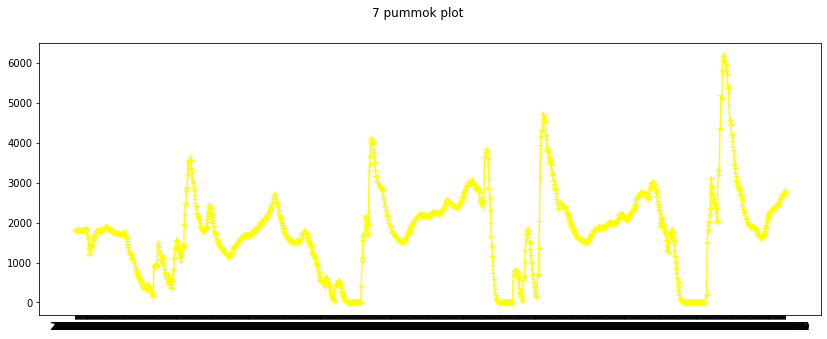

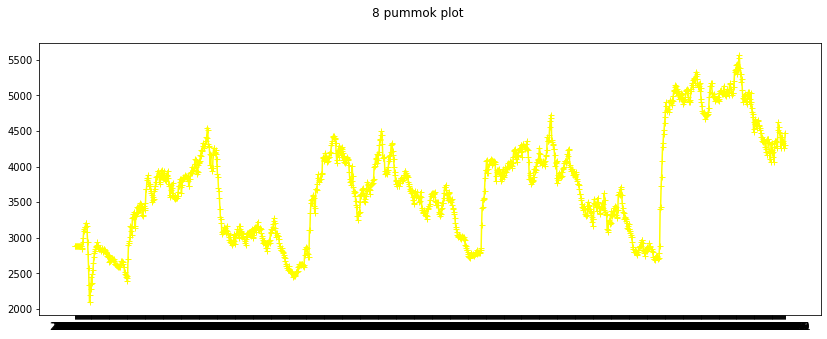

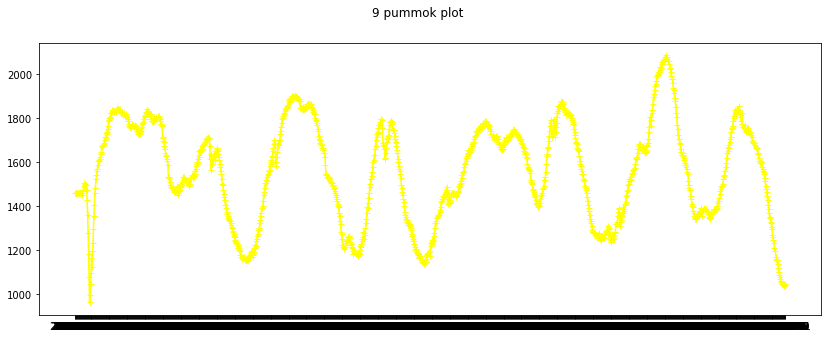

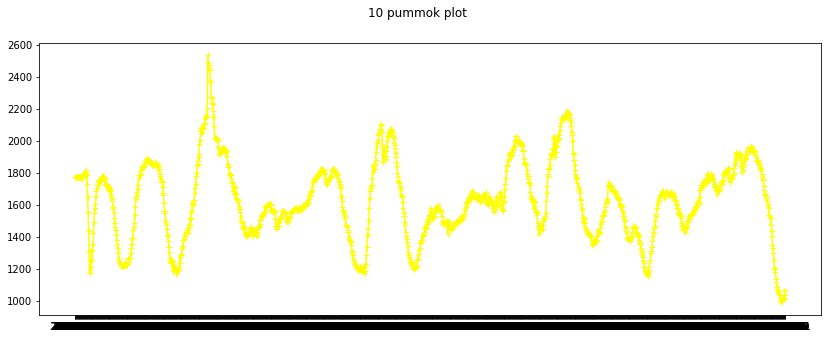

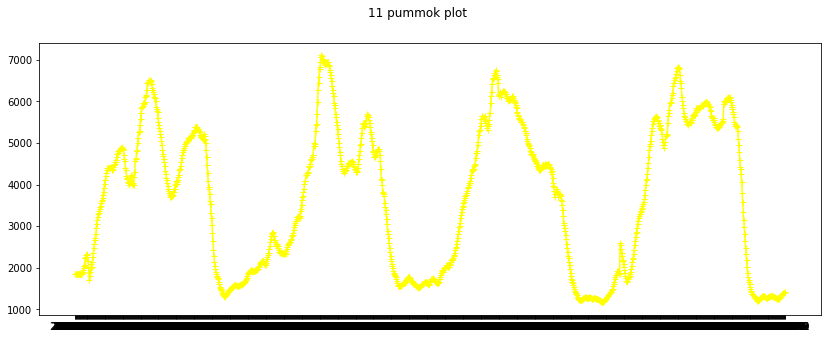

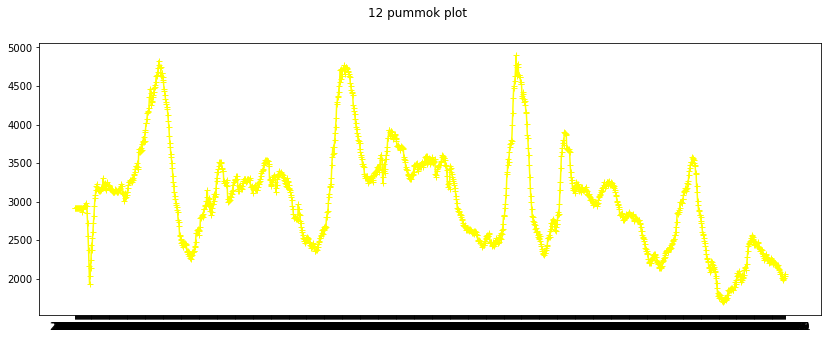

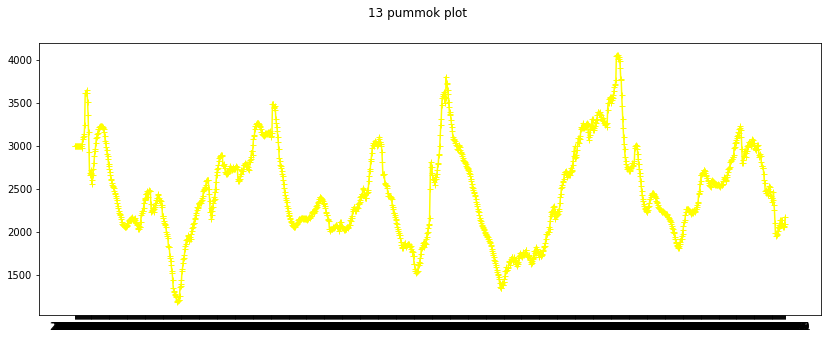

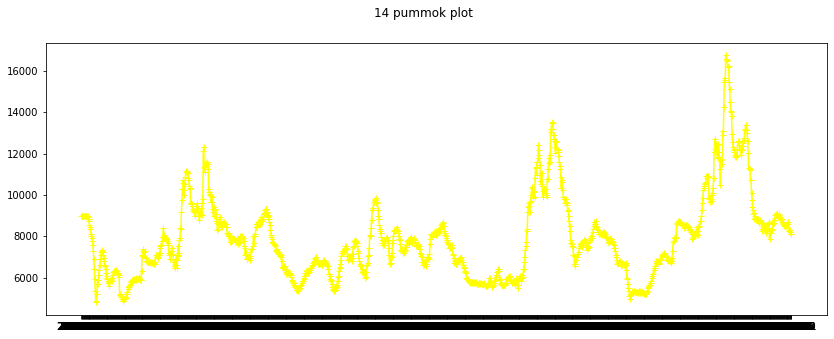

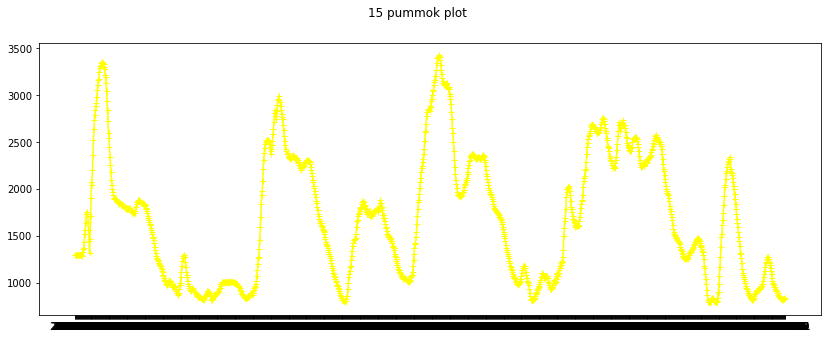

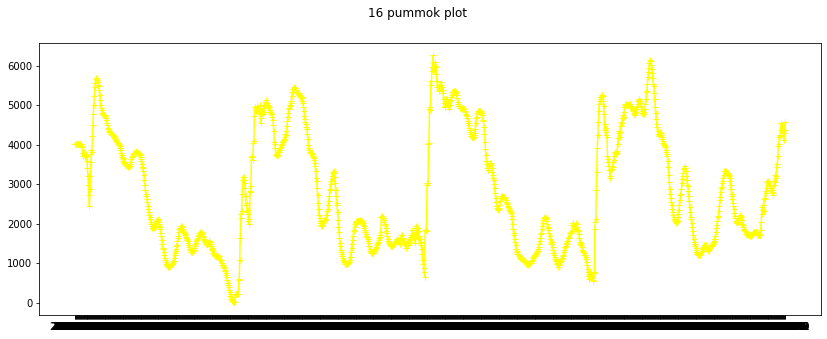

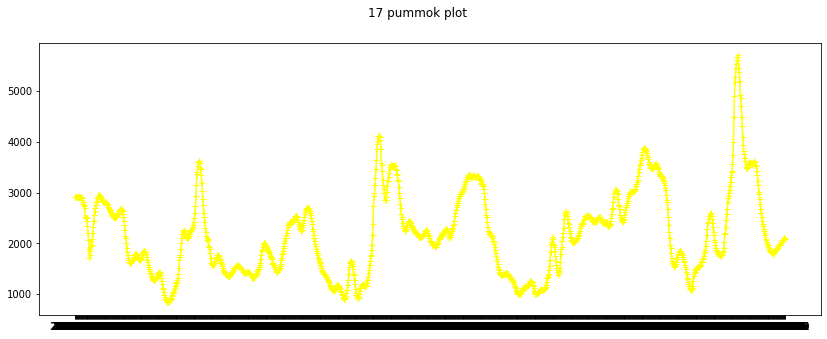

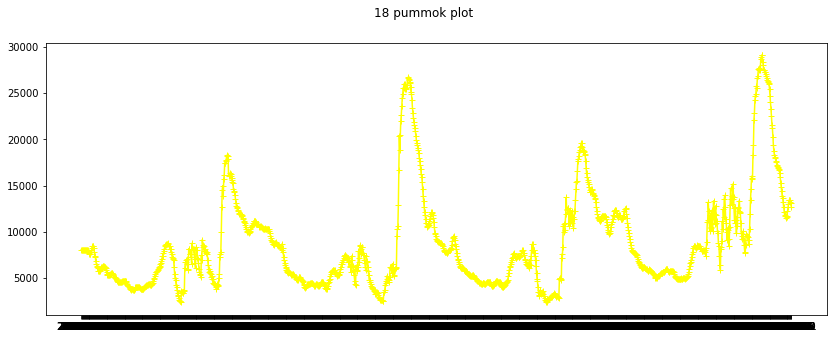

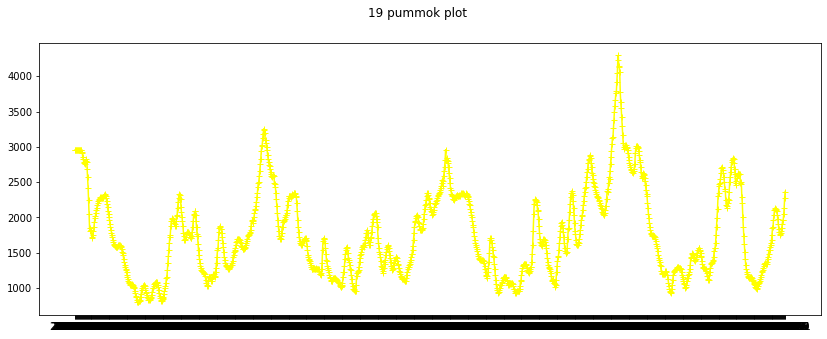

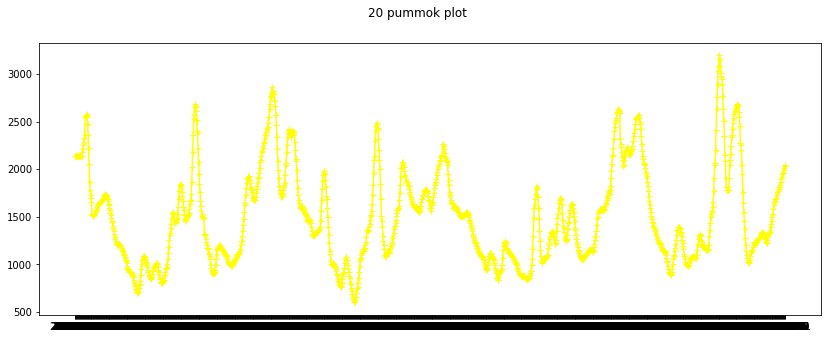

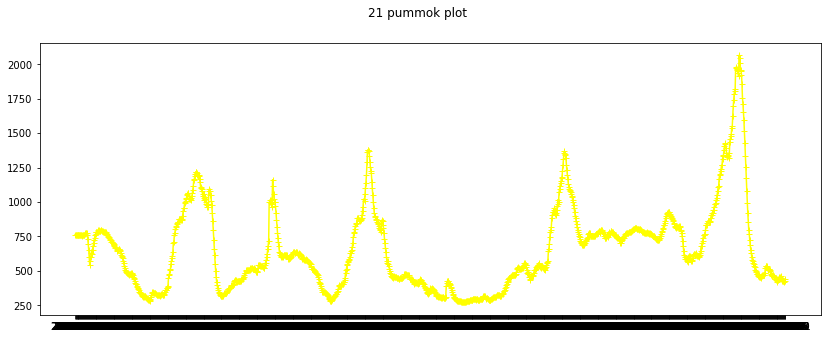

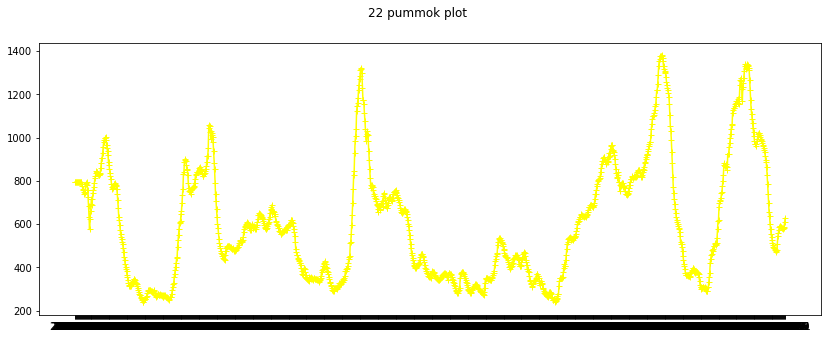

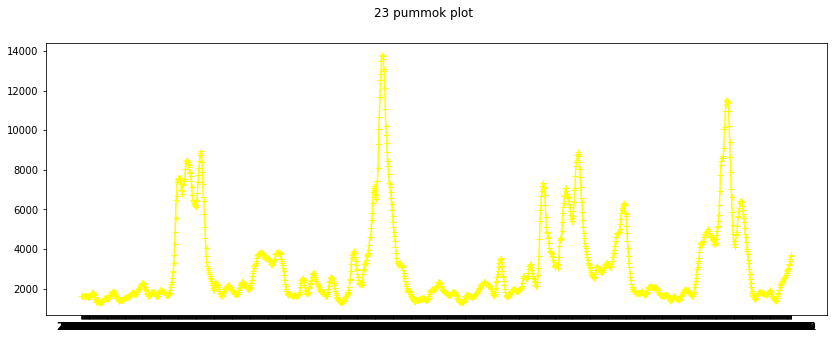

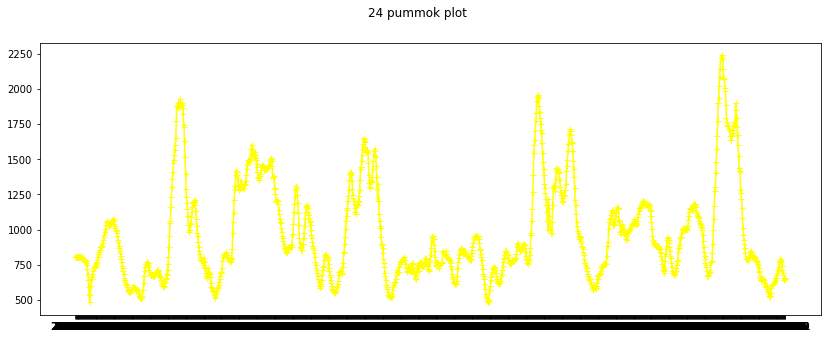

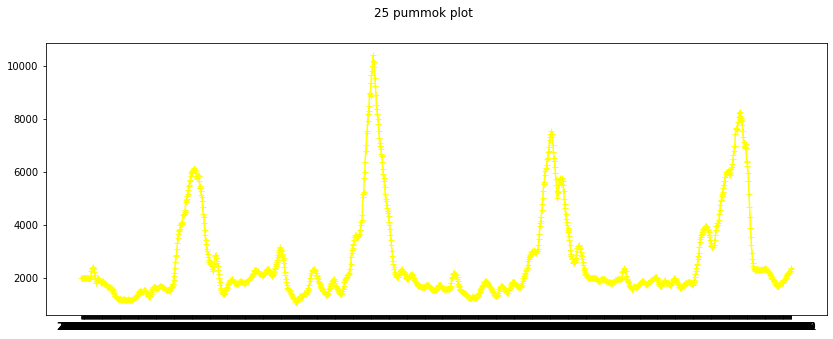

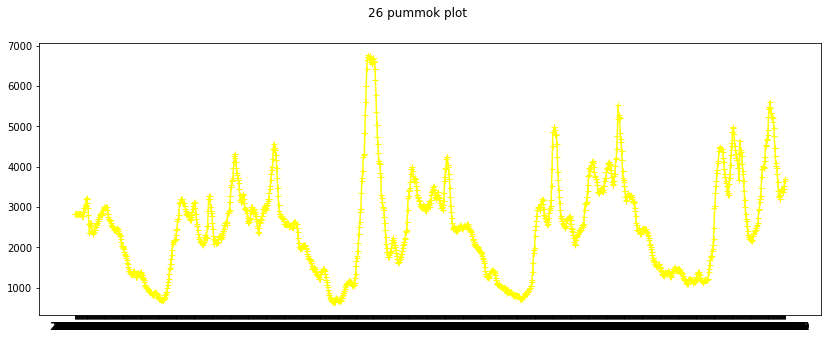

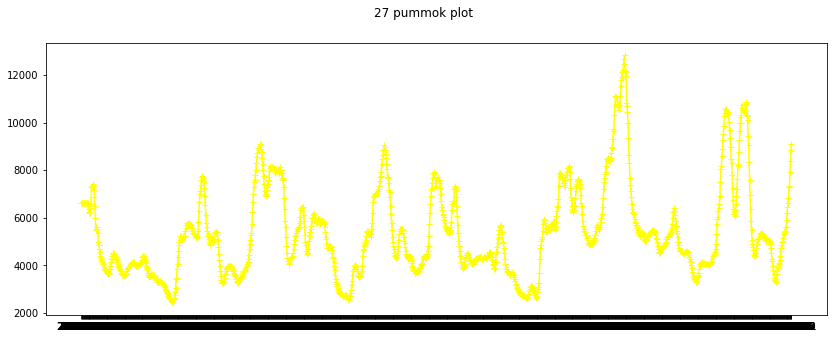

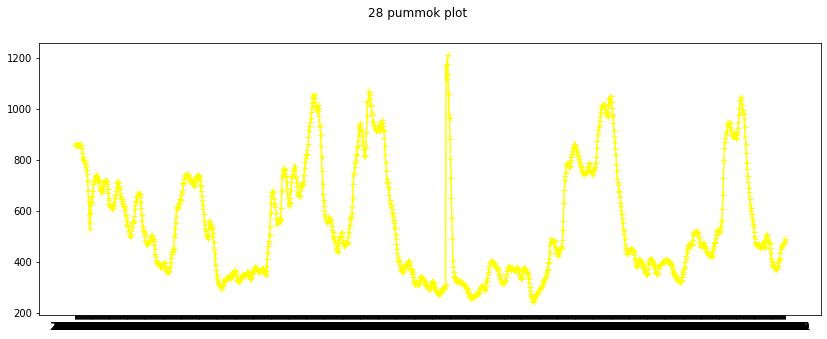

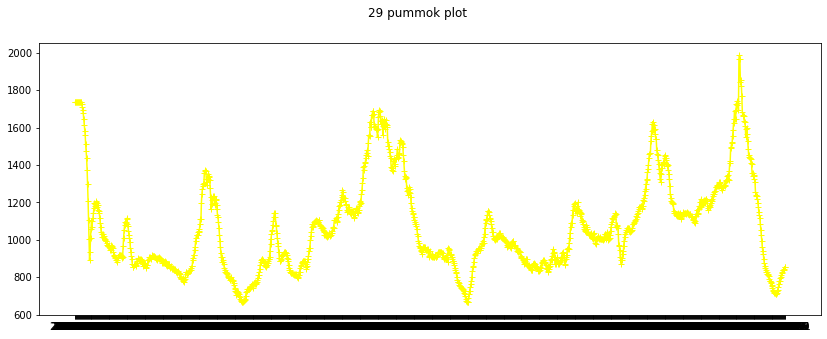

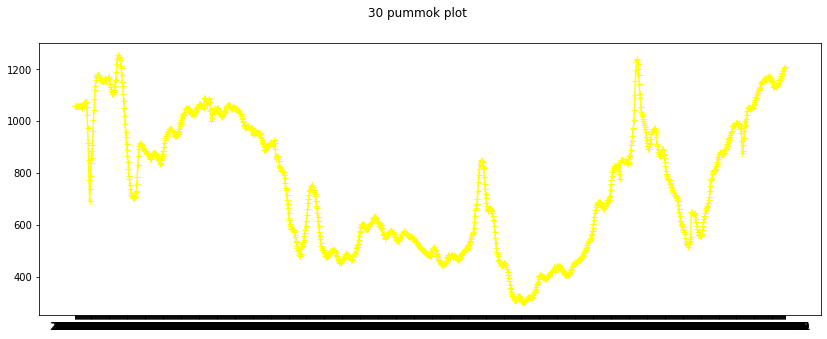

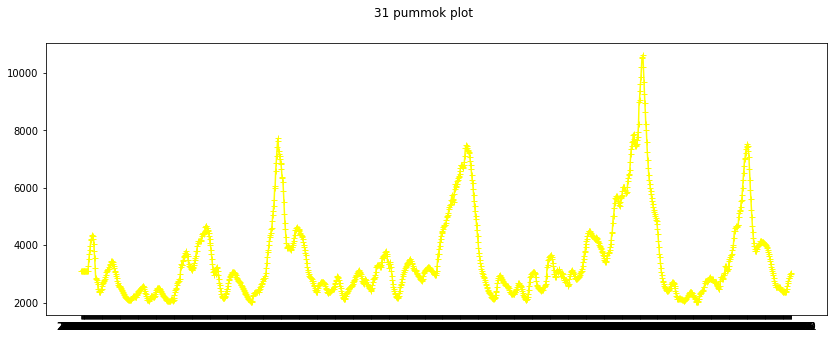

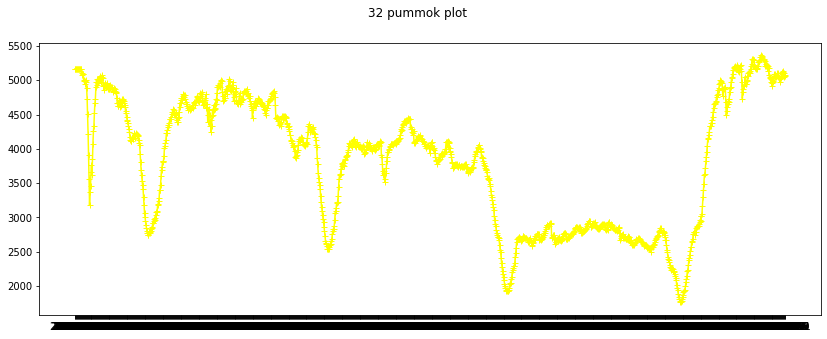

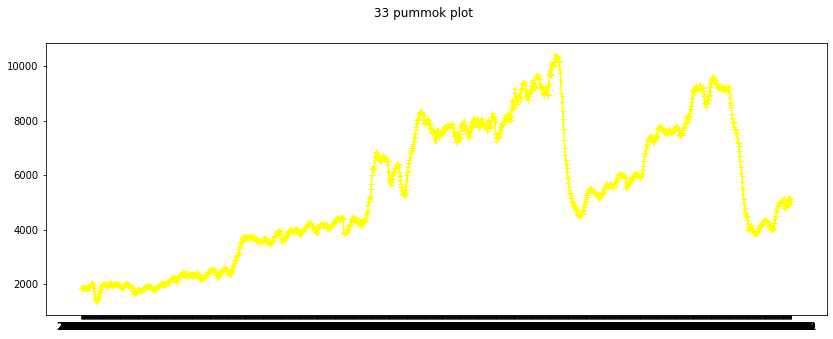

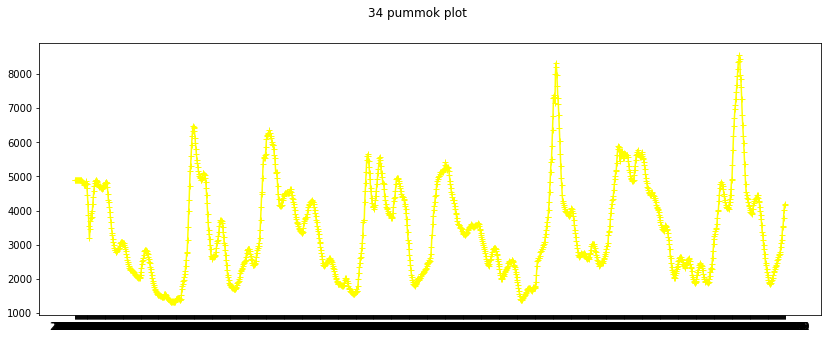

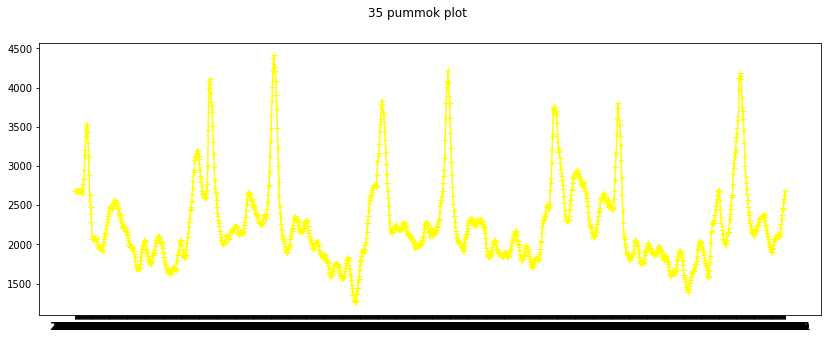

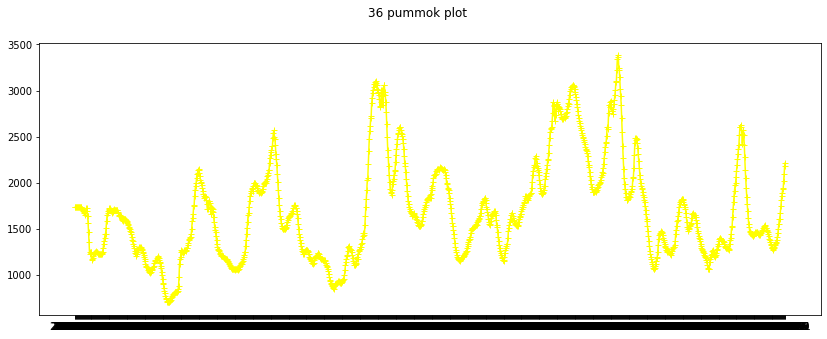

In [26]:
# 변경된거 한번 확인
for i in range(37):
  df= globals()[f'train_smoothing_{i}']
  plt.figure(figsize=(14,5))
  plt.plot(df['해당일자_전체평균가격(원)'], marker='+', color='yellow')
  #plt.plot(df['wma7'],  marker='*', color='yellow')
  # plt.plot(df['wma14'],  marker='s', color='yellow')

  plt.suptitle(f'{i} pummok plot')
  plt.show()
  plt.close()

In [27]:
# OLS Feature selection을 위한 함수
def OLS_report(df, seed):
    
    
    
    if len(df.columns)<len(train_smoothing_0.columns): # 주산지2의 날씨 데이터가 없다. 예외처리
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    else:
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+초기온도_2+최대온도_2+최저온도_2+ 평균온도_2+강수량_2+ 습도_2 +일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    return model.fit()




def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff
                              #  "conf_lower":conf_lower,
                              #  "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals"]]
    return results_df





def OLS_feature_selection(df):
  df.columns = df.columns.str.replace(r'\([^)]*\)','',regex= True) # 컬럼에서 문자 기호 같은거 있으면 OLS 안돌아간다.     
                                                                  # 테스트 데이터에도 적용해야한다. 컬럼명 바꿔야하니깐.
  result = OLS_report(df,42)
  ols_report_df = results_summary_to_dataframe(result).reset_index()
  ols_report_df = ols_report_df[ols_report_df['index'] !='Intercept']
  selected_col = list(ols_report_df[ols_report_df['pvals']<0.05]['index'].values) 
  selected_df = df[selected_col]
  selected_df['해당일자_전체평균가격'] = df['해당일자_전체평균가격']
  return selected_df        

In [28]:
# 유의수준을 토대로 columns selection
for i in range(37):
  globals()[f'total_{i}'] = OLS_feature_selection(globals()[f'train_smoothing_{i}'])

In [29]:
# 품목별로 컬럼 확인
for i in range(37):
  print(f"{i} 품목의 selected_columns : {list(globals()[f'total_{i}'].columns)}")

0 품목의 selected_columns : ['단가', '습도_0', '최저온도_1', '평균온도_1', '최대온도_2', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_최소', '해당일자_전체평균가격']
1 품목의 selected_columns : ['단가', '거래량', '습도_0', '최대온도_1', '평균온도_1', '습도_1', '최대온도_2', '최저온도_2', '평균온도_2', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '해당일자_전체평균가격']
2 품목의 selected_columns : ['단가', '거래량', '습도_0', '최저온도_1', '습도_1', '최저온도_2', '습도_2', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입금액', '무역수지', '해당일자_전체평균가격']
3 품목의 selected_columns : ['단가', '거래량', '최저온도_1', '평균온도_1', '습도_1', '일자별_domae가격_평균', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입중량', '수입금액', '무역수지', '해당일자_전체평균가격']
4 품목의 selected_columns : ['단가', '거래량', '최저온도_0', '평균온도_1', '최저온도_2', '습도_2', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_최소', '수출중량', '해당일자_전체평균가격']
5 품목의 selected_columns : ['단가', '거래량', '최대온도_0', '평

In [30]:
for i in range(37):
  print(globals()[f'total_{i}']['해당일자_전체평균가격'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [31]:
def scaling_df(df):
  scaler = StandardScaler()
  
  
  tmp = df.drop('해당일자_전체평균가격',axis=1).copy()
  scaler.fit(tmp)
  df_scaled = scaler.transform(tmp)
  df_scaled = pd.DataFrame(data=df_scaled, columns = tmp.columns)
  df_scaled['해당일자_전체평균가격'] = df['해당일자_전체평균가격'].values 
  return df_scaled

for i in range(37):
  globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])

In [32]:
for i in range(37):
  print(globals()[f'train_scaled_{i}'].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [33]:
globals()[f'train_scaled_0']

,단가,습도_0,최저온도_1,평균온도_1,최대온도_2,습도_2,일자별_domae가격_최대,일자별_domae가격_평균,일자별_domae가격_최소,일자별_somae가격_최대,일자별_somae가격_최소,해당일자_전체평균가격
0,-1.562158,0.0,-0.839649,-1.055373,-0.883624,0.232086,-1.349171,-1.352255,-1.350599,-1.324653,-1.342761,4609.189974
1,6.636992,0.0,-0.606699,-0.673602,-0.789047,-0.017175,0.622351,0.694492,0.713407,0.577939,0.777304,4609.189974
2,0.611502,0.0,-0.723174,-0.883576,-0.949829,-0.391066,0.622351,0.694492,0.713407,0.577939,0.777304,4609.189974
3,1.017981,0.0,-0.785891,-0.845399,-0.770131,0.120809,0.622351,0.694492,0.713407,0.577939,0.777304,4609.189974
4,1.516286,0.0,-0.839649,-0.902665,-0.940371,-0.773859,0.622351,0.694492,0.713407,0.577939,0.777304,4609.189974
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-1.562158,0.0,-0.741093,-0.959930,-0.817420,-0.017175,-1.349171,-1.352255,-1.350599,-1.324653,-1.342761,7303.582841
1457,1.422662,0.0,-0.606699,-0.664058,-0.580976,0.427934,1.115232,1.127194,1.140443,1.532417,0.856559,7184.212772
1458,1.433806,0.0,-0.785891,-1.084005,-1.309223,1.327053,1.115232,1.127194,1.140443,1.532417,0.856559,7128.611449
1459,1.881196,0.0,-1.529540,-1.866634,-2.207711,-1.299087,1.115232,1.127194,1.140443,1.532417,0.856559,7078.578326


In [34]:
try_cnt = 15 # 모델이나 체크포인트를 각자 다른 폴더에 저장해주기 위해
            # 새로운거 시도할때마다 숫자 바꿔서 내면된다.


In [35]:
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [36]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [37]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(28)(x) # 4주 예측
    return keras.Model(inputs, outputs)

In [38]:
def call_back_set(name, epoch, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=100)

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}') == False:
        os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}')

    filename = f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/{name}-{epoch}-{batch_size}.h5'

    checkpoint = ModelCheckpoint(filename,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto'
                                 )
    return [early_stopping, checkpoint]

In [39]:
def train(x_train, y_train, x_val, y_val, name, epoch, batch_size, learning_rate = 0.001, verbose = 1):


    model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )


    # Train the model
    with tf.device('/device:GPU:0'):
        history1 = model.fit(
            x_train, y_train,
            epochs = epoch,
            steps_per_epoch=len(x_train) / batch_size,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            validation_steps=len(x_val) / batch_size,
            shuffle=False,
            callbacks=call_back_set(name, epoch, batch_size),
            verbose=verbose)

    return model

In [40]:
def time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in tqdm(range(len(df) - seqence_length)):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

In [41]:
epoch = 1000
batch = 15

In [42]:
for i in range(37):


    df_number = i
    df = globals()[f'train_scaled_{i}']
    
    # nan 처리
    df.fillna(0, inplace = True)
    
  

    

    # 변수와 타겟 분리
    x, y = df[[i for i in df.columns if i != '해당일자_전체평균가격']], df['해당일자_전체평균가격']

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # time series window 생성
    data_x = time_window(x, 13, 1)
    data_y = time_window(y, 27, 1)

    # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    # train, validation 분리 (8 : 2)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=False, random_state=119)

    # transformer 모델 훈련
    transformer = train(astype_data(x_train), y_train, astype_data(x_val), y_val, f'transformer-{df_number}', epoch, batch)
    transformer.load_weights(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}') == False:
         os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}')

    
    
    
    # 모델 저장
    transformer.save(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

100%|██████████| 1419/1419 [00:00<00:00, 31375.36it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 8850867.0000
Epoch 1: val_loss improved from inf to 1829688.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-0-1000-15.h5
75/75 [==============================] - 17s 22ms/step - loss: 8850867.0000 - val_loss: 1829688.6250
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 1456534.1250
Epoch 2: val_loss did not improve from 1829688.62500
75/75 [==============================] - 1s 15ms/step - loss: 1435268.0000 - val_loss: 3031516.0000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 2010539.0000
Epoch 3: val_loss improved from 1829688.62500 to 1525756.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-0-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 2010539.0000 - val_loss: 1525756.3750
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 1563552.0000
Epoch 4: val_loss improv

100%|██████████| 1419/1419 [00:00<00:00, 36603.20it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 2033137.3750
Epoch 1: val_loss improved from inf to 212467.28125, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-1-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 2033137.3750 - val_loss: 212467.2812
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 547880.5000
Epoch 2: val_loss improved from 212467.28125 to 86000.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-1-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 547880.5000 - val_loss: 86000.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 540503.9375
Epoch 3: val_loss improved from 86000.50000 to 55188.24609, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-1-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 523187.1875 - val_loss: 55188.2461
Epoch 4/1000
73/75 [========

100%|██████████| 1419/1419 [00:00<00:00, 35330.36it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 3124375.0000
Epoch 1: val_loss improved from inf to 1381439.12500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-2-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 3124375.0000 - val_loss: 1381439.1250
Epoch 2/1000
75/75 [============================>.] - ETA: 0s - loss: 308798.2500
Epoch 2: val_loss did not improve from 1381439.12500
75/75 [==============================] - 1s 14ms/step - loss: 308198.4688 - val_loss: 1903004.8750
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 275093.9688
Epoch 3: val_loss did not improve from 1381439.12500
75/75 [==============================] - 1s 14ms/step - loss: 269764.9062 - val_loss: 2303539.7500
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 294868.0625
Epoch 4: val_loss did not improve from 1381439.12500
75/75 [==============================] - 1s 14ms/step - loss: 290042.5000 

100%|██████████| 1419/1419 [00:00<00:00, 33296.69it/s]


Epoch 1/1000
75/75 [============================>.] - ETA: 0s - loss: 3391902.5000
Epoch 1: val_loss improved from inf to 887632.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-3-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 3364802.0000 - val_loss: 887632.5625
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 332376.9688
Epoch 2: val_loss did not improve from 887632.56250
75/75 [==============================] - 1s 14ms/step - loss: 327319.4688 - val_loss: 2101731.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 358658.7188
Epoch 3: val_loss did not improve from 887632.56250
75/75 [==============================] - 1s 14ms/step - loss: 352027.0938 - val_loss: 1900891.0000
Epoch 4/1000
75/75 [============================>.] - ETA: 0s - loss: 345368.5625
Epoch 4: val_loss did not improve from 887632.56250
75/75 [==============================] - 1s 14ms/step - loss: 343129.5938 - val

100%|██████████| 1419/1419 [00:00<00:00, 34454.57it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 2939519.0000
Epoch 1: val_loss improved from inf to 409295.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-4-1000-15.h5
75/75 [==============================] - 4s 20ms/step - loss: 2939519.0000 - val_loss: 409295.5625
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 643511.3750
Epoch 2: val_loss improved from 409295.56250 to 406162.15625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-4-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 632357.8125 - val_loss: 406162.1562
Epoch 3/1000
75/75 [============================>.] - ETA: 0s - loss: 537582.1875
Epoch 3: val_loss improved from 406162.15625 to 403432.15625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-4-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 536267.8750 - val_loss: 403432.1562
Epoch 4/1000
73/75 [===

100%|██████████| 1419/1419 [00:00<00:00, 33471.03it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 14901015.0000
Epoch 1: val_loss improved from inf to 7371626.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-5-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 14977149.0000 - val_loss: 7371626.5000
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 1677386.5000
Epoch 2: val_loss improved from 7371626.50000 to 3007461.75000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-5-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 1706629.1250 - val_loss: 3007461.7500
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 2106974.2500
Epoch 3: val_loss improved from 3007461.75000 to 1478222.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-5-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 2130664.2500 - val_loss: 1478222.5000
Epoch 4/1

100%|██████████| 1419/1419 [00:00<00:00, 34695.39it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 34210700.0000
Epoch 1: val_loss improved from inf to 41819380.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-6-1000-15.h5
75/75 [==============================] - 4s 19ms/step - loss: 34210700.0000 - val_loss: 41819380.0000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 21265808.0000
Epoch 2: val_loss improved from 41819380.00000 to 25570474.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-6-1000-15.h5
75/75 [==============================] - 1s 13ms/step - loss: 21265808.0000 - val_loss: 25570474.0000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 18264940.0000
Epoch 3: val_loss improved from 25570474.00000 to 25444796.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-6-1000-15.h5
75/75 [==============================] - 1s 13ms/step - loss: 18264940.0000 - val_loss: 25444796.00

100%|██████████| 1419/1419 [00:00<00:00, 32061.40it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 3187226.0000
Epoch 1: val_loss improved from inf to 2518825.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-7-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 3187226.0000 - val_loss: 2518825.5000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 1030203.1250
Epoch 2: val_loss improved from 2518825.50000 to 1900797.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-7-1000-15.h5
75/75 [==============================] - 1s 14ms/step - loss: 1030203.1250 - val_loss: 1900797.5000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 837306.3750
Epoch 3: val_loss improved from 1900797.50000 to 1432824.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-7-1000-15.h5
75/75 [==============================] - 1s 14ms/step - loss: 837306.3750 - val_loss: 1432824.6250
Epoch 4/1000


100%|██████████| 1419/1419 [00:00<00:00, 29242.74it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 10225339.0000
Epoch 1: val_loss improved from inf to 1326786.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-8-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 9887253.0000 - val_loss: 1326786.0000
Epoch 2/1000
75/75 [============================>.] - ETA: 0s - loss: 655988.3750
Epoch 2: val_loss improved from 1326786.00000 to 879493.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-8-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 656827.5625 - val_loss: 879493.3750
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 833335.3125
Epoch 3: val_loss improved from 879493.37500 to 775826.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-8-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 825690.0000 - val_loss: 775826.5625
Epoch 4/1000
73/75 

100%|██████████| 1419/1419 [00:00<00:00, 32338.38it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 2007712.1250
Epoch 1: val_loss improved from inf to 505705.34375, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-9-1000-15.h5
75/75 [==============================] - 5s 26ms/step - loss: 1953116.7500 - val_loss: 505705.3438
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 262610.1250
Epoch 2: val_loss improved from 505705.34375 to 158337.93750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-9-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 261911.5469 - val_loss: 158337.9375
Epoch 3/1000
75/75 [============================>.] - ETA: 0s - loss: 174568.9531
Epoch 3: val_loss improved from 158337.93750 to 78374.90625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-9-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 173703.7188 - val_loss: 78374.9062
Epoch 4/1000
73/75 [=====

100%|██████████| 1419/1419 [00:00<00:00, 32908.05it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 2013294.2500
Epoch 1: val_loss improved from inf to 378071.15625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-10-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 2013294.2500 - val_loss: 378071.1562
Epoch 2/1000
75/75 [============================>.] - ETA: 0s - loss: 146152.4062
Epoch 2: val_loss improved from 378071.15625 to 88333.53125, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-10-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 145658.0625 - val_loss: 88333.5312
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 131363.6719
Epoch 3: val_loss improved from 88333.53125 to 77153.32031, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-10-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 131363.6719 - val_loss: 77153.3203
Epoch 4/1000
75/75 [=====

100%|██████████| 1419/1419 [00:00<00:00, 32283.65it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 14519496.0000
Epoch 1: val_loss improved from inf to 11715926.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-11-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 14519496.0000 - val_loss: 11715926.0000
Epoch 2/1000
76/75 [==============================] - ETA: 0s - loss: 4356393.5000
Epoch 2: val_loss improved from 11715926.00000 to 1426132.87500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-11-1000-15.h5
75/75 [==============================] - 1s 14ms/step - loss: 4356393.5000 - val_loss: 1426132.8750
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 2661404.7500
Epoch 3: val_loss improved from 1426132.87500 to 1391556.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-11-1000-15.h5
75/75 [==============================] - 1s 13ms/step - loss: 2661404.7500 - val_loss: 1391556.6250
Epo

100%|██████████| 1419/1419 [00:00<00:00, 33170.14it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 8647824.0000
Epoch 1: val_loss improved from inf to 2593007.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-12-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 8362355.5000 - val_loss: 2593007.5000
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 664342.6250
Epoch 2: val_loss improved from 2593007.50000 to 843889.31250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-12-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 653982.6875 - val_loss: 843889.3125
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 642832.3125
Epoch 3: val_loss did not improve from 843889.31250
75/75 [==============================] - 1s 15ms/step - loss: 625896.0625 - val_loss: 878562.7500
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 604332.6250
Epoch 4: val_loss did not improv

100%|██████████| 1419/1419 [00:00<00:00, 31648.64it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 5254803.0000
Epoch 1: val_loss improved from inf to 188751.15625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-13-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 5123820.5000 - val_loss: 188751.1562
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 963420.7500
Epoch 2: val_loss did not improve from 188751.15625
75/75 [==============================] - 1s 15ms/step - loss: 950042.0625 - val_loss: 223664.9688
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 595940.7500
Epoch 3: val_loss improved from 188751.15625 to 167984.78125, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-13-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 595493.2500 - val_loss: 167984.7812
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 568190.8125
Epoch 4: val_loss improved from 167

100%|██████████| 1419/1419 [00:00<00:00, 31488.74it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 53188768.0000
Epoch 1: val_loss improved from inf to 56323900.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-14-1000-15.h5
75/75 [==============================] - 5s 22ms/step - loss: 53188768.0000 - val_loss: 56323900.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 9778146.0000 
Epoch 2: val_loss improved from 56323900.00000 to 3841130.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-14-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 9620840.0000 - val_loss: 3841130.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 4786674.0000
Epoch 3: val_loss improved from 3841130.00000 to 3642867.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-14-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 4800117.5000 - val_loss: 3642867.2500
Ep

100%|██████████| 1419/1419 [00:00<00:00, 34606.23it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 2729969.2500
Epoch 1: val_loss improved from inf to 1066636.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-15-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 2655282.5000 - val_loss: 1066636.5000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 982050.6875 
Epoch 2: val_loss improved from 1066636.50000 to 844601.06250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-15-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 954234.5625 - val_loss: 844601.0625
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 596479.5625
Epoch 3: val_loss improved from 844601.06250 to 493936.71875, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-15-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 590168.5000 - val_loss: 493936.7188
Epoch 4/1000
73/

100%|██████████| 1419/1419 [00:00<00:00, 33423.47it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 9542881.0000
Epoch 1: val_loss improved from inf to 4199148.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-16-1000-15.h5
75/75 [==============================] - 5s 22ms/step - loss: 9542881.0000 - val_loss: 4199148.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 1781579.0000
Epoch 2: val_loss improved from 4199148.00000 to 1091167.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-16-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 1784655.1250 - val_loss: 1091167.2500
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 960253.8125
Epoch 3: val_loss improved from 1091167.25000 to 1020982.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-16-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 952729.9375 - val_loss: 1020982.5625
Epoch 4/10

100%|██████████| 1419/1419 [00:00<00:00, 32738.62it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 3562315.2500
Epoch 1: val_loss improved from inf to 1270200.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-17-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 3469791.5000 - val_loss: 1270200.6250
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 938494.1875
Epoch 2: val_loss did not improve from 1270200.62500
75/75 [==============================] - 1s 15ms/step - loss: 950665.8125 - val_loss: 2029157.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 796969.5625
Epoch 3: val_loss did not improve from 1270200.62500
75/75 [==============================] - 1s 15ms/step - loss: 811945.6250 - val_loss: 1309524.8750
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 650991.6875
Epoch 4: val_loss improved from 1270200.62500 to 1141888.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/t

100%|██████████| 1419/1419 [00:00<00:00, 34851.02it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 84400912.0000
Epoch 1: val_loss improved from inf to 145928224.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-18-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 83216840.0000 - val_loss: 145928224.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 33406670.0000
Epoch 2: val_loss improved from 145928224.00000 to 46634680.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-18-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 32408610.0000 - val_loss: 46634680.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 26617378.0000
Epoch 3: val_loss improved from 46634680.00000 to 46507536.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-18-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 25845080.0000 - val_loss: 46507

100%|██████████| 1419/1419 [00:00<00:00, 33129.52it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 2237307.2500
Epoch 1: val_loss improved from inf to 2610515.25000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-19-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 2186646.7500 - val_loss: 2610515.2500
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 749669.8750
Epoch 2: val_loss improved from 2610515.25000 to 471421.28125, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-19-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 776890.8750 - val_loss: 471421.2812
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 586889.1250
Epoch 3: val_loss improved from 471421.28125 to 415608.40625, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-19-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 623650.9375 - val_loss: 415608.4062
Epoch 4/1000
73/7

100%|██████████| 1419/1419 [00:00<00:00, 27182.87it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 1898420.7500
Epoch 1: val_loss improved from inf to 773545.31250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-20-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 1861245.0000 - val_loss: 773545.3125
Epoch 2/1000
74/75 [============================>.] - ETA: 0s - loss: 478123.3125
Epoch 2: val_loss improved from 773545.31250 to 345280.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-20-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 492492.9062 - val_loss: 345280.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 296359.8750
Epoch 3: val_loss improved from 345280.00000 to 336686.37500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-20-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 322146.0625 - val_loss: 336686.3750
Epoch 4/1000
76/75 [

100%|██████████| 1419/1419 [00:00<00:00, 32017.76it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 271357.9375
Epoch 1: val_loss improved from inf to 154989.23438, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-21-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 263121.8438 - val_loss: 154989.2344
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 118820.3438
Epoch 2: val_loss did not improve from 154989.23438
75/75 [==============================] - 1s 15ms/step - loss: 116897.4375 - val_loss: 178961.0469
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 77735.0156
Epoch 3: val_loss improved from 154989.23438 to 136631.98438, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-21-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 75711.1250 - val_loss: 136631.9844
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 72304.7891
Epoch 4: val_loss improved from 136631.9

100%|██████████| 1419/1419 [00:00<00:00, 28796.91it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 245582.5469
Epoch 1: val_loss improved from inf to 110584.94531, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-22-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 238233.2656 - val_loss: 110584.9453
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 92933.6641
Epoch 2: val_loss did not improve from 110584.94531
75/75 [==============================] - 1s 15ms/step - loss: 99856.1094 - val_loss: 298335.0625
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 87371.2109
Epoch 3: val_loss did not improve from 110584.94531
75/75 [==============================] - 1s 15ms/step - loss: 91832.2734 - val_loss: 259205.3281
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 85452.9297
Epoch 4: val_loss did not improve from 110584.94531
75/75 [==============================] - 1s 15ms/step - loss: 89818.4141 - val_loss: 24

100%|██████████| 1419/1419 [00:00<00:00, 31925.70it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 12627606.0000
Epoch 1: val_loss improved from inf to 6086191.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-23-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 12253225.0000 - val_loss: 6086191.5000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 5406651.5000
Epoch 2: val_loss improved from 6086191.50000 to 5619495.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-23-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 5307454.5000 - val_loss: 5619495.5000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 4455874.0000
Epoch 3: val_loss improved from 5619495.50000 to 3284301.75000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-23-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 4455874.0000 - val_loss: 3284301.7500
Epoch 

100%|██████████| 1419/1419 [00:00<00:00, 32821.49it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 752935.1875
Epoch 1: val_loss improved from inf to 239599.54688, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-24-1000-15.h5
75/75 [==============================] - 5s 19ms/step - loss: 728305.7500 - val_loss: 239599.5469
Epoch 2/1000
72/75 [===========================>..] - ETA: 0s - loss: 181026.6875
Epoch 2: val_loss improved from 239599.54688 to 170587.01562, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-24-1000-15.h5
75/75 [==============================] - 1s 14ms/step - loss: 173875.5781 - val_loss: 170587.0156
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 152098.3281
Epoch 3: val_loss did not improve from 170587.01562
75/75 [==============================] - 1s 13ms/step - loss: 149377.4844 - val_loss: 172748.4531
Epoch 4/1000
75/75 [============================>.] - ETA: 0s - loss: 151047.3594
Epoch 4: val_loss improved from 17058

100%|██████████| 1419/1419 [00:00<00:00, 32169.01it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 8234064.5000
Epoch 1: val_loss improved from inf to 6954137.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-25-1000-15.h5
75/75 [==============================] - 5s 22ms/step - loss: 8234064.5000 - val_loss: 6954137.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 2855721.2500
Epoch 2: val_loss improved from 6954137.00000 to 2390149.75000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-25-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 2765946.5000 - val_loss: 2390149.7500
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 2443068.7500
Epoch 3: val_loss improved from 2390149.75000 to 2204718.75000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-25-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 2369945.7500 - val_loss: 2204718.7500
Epoch 4/

100%|██████████| 1419/1419 [00:00<00:00, 29909.93it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 6166552.0000
Epoch 1: val_loss improved from inf to 1849120.62500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-26-1000-15.h5
75/75 [==============================] - 5s 23ms/step - loss: 6166552.0000 - val_loss: 1849120.6250
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 1908829.0000
Epoch 2: val_loss improved from 1849120.62500 to 1720121.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-26-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 1899769.8750 - val_loss: 1720121.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 1815722.1250
Epoch 3: val_loss improved from 1720121.50000 to 1601553.12500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-26-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 1776060.2500 - val_loss: 1601553.1250
Epoch 4/

100%|██████████| 1419/1419 [00:00<00:00, 30723.14it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 26813800.0000
Epoch 1: val_loss improved from inf to 9730994.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-27-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 26813800.0000 - val_loss: 9730994.0000
Epoch 2/1000
72/75 [===========================>..] - ETA: 0s - loss: 3828980.5000
Epoch 2: val_loss improved from 9730994.00000 to 4868965.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-27-1000-15.h5
75/75 [==============================] - 1s 14ms/step - loss: 4367920.5000 - val_loss: 4868965.0000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 4721378.0000
Epoch 3: val_loss improved from 4868965.00000 to 4050724.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-27-1000-15.h5
75/75 [==============================] - 1s 15ms/step - loss: 4721378.0000 - val_loss: 4050724.5000
Epoch 

100%|██████████| 1419/1419 [00:00<00:00, 31404.50it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 267952.9375
Epoch 1: val_loss improved from inf to 121586.50781, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-28-1000-15.h5
75/75 [==============================] - 5s 22ms/step - loss: 262199.2812 - val_loss: 121586.5078
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 98614.6484
Epoch 2: val_loss improved from 121586.50781 to 26922.95898, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-28-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 95805.1641 - val_loss: 26922.9590
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 57364.9805
Epoch 3: val_loss did not improve from 26922.95898
75/75 [==============================] - 1s 16ms/step - loss: 57364.9805 - val_loss: 29674.9922
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 69792.7188
Epoch 4: val_loss improved from 26922.95898 to

100%|██████████| 1419/1419 [00:00<00:00, 26680.34it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 879857.0625
Epoch 1: val_loss improved from inf to 182486.96875, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-29-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 870536.9375 - val_loss: 182486.9688
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 188400.9062
Epoch 2: val_loss did not improve from 182486.96875
75/75 [==============================] - 1s 15ms/step - loss: 190294.7500 - val_loss: 268910.0312
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 136804.6875
Epoch 3: val_loss did not improve from 182486.96875
75/75 [==============================] - 1s 15ms/step - loss: 137840.7500 - val_loss: 271390.5938
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 121649.7578
Epoch 4: val_loss improved from 182486.96875 to 168131.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer

100%|██████████| 1419/1419 [00:00<00:00, 29893.41it/s]


Epoch 1/1000
76/75 [==============================] - ETA: 0s - loss: 441862.1875
Epoch 1: val_loss improved from inf to 43927.83203, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-30-1000-15.h5
75/75 [==============================] - 5s 23ms/step - loss: 441862.1875 - val_loss: 43927.8320
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 48698.6367
Epoch 2: val_loss did not improve from 43927.83203
75/75 [==============================] - 1s 16ms/step - loss: 54267.5586 - val_loss: 95751.2422
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 46728.7148
Epoch 3: val_loss did not improve from 43927.83203
75/75 [==============================] - 1s 16ms/step - loss: 53562.4727 - val_loss: 116966.6797
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 51331.7539
Epoch 4: val_loss did not improve from 43927.83203
75/75 [==============================] - 1s 16ms/step - loss: 56646.4453 - val_loss: 103590.0

100%|██████████| 1419/1419 [00:00<00:00, 32713.79it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 11260358.0000
Epoch 1: val_loss improved from inf to 5454955.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-31-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 12419925.0000 - val_loss: 5454955.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 2588100.7500
Epoch 2: val_loss did not improve from 5454955.00000
75/75 [==============================] - 1s 15ms/step - loss: 2946889.5000 - val_loss: 5528567.5000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 3214802.0000
Epoch 3: val_loss improved from 5454955.00000 to 1905422.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-31-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 3639080.2500 - val_loss: 1905422.0000
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 1831122.2500
Epoch 4: val_loss imp

100%|██████████| 1419/1419 [00:00<00:00, 26978.46it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 13624886.0000
Epoch 1: val_loss improved from inf to 2577393.50000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-32-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 13338584.0000 - val_loss: 2577393.5000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 1264472.0000
Epoch 2: val_loss did not improve from 2577393.50000
75/75 [==============================] - 1s 15ms/step - loss: 1340826.3750 - val_loss: 3377272.0000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 1723094.8750
Epoch 3: val_loss did not improve from 2577393.50000
75/75 [==============================] - 1s 15ms/step - loss: 1723094.8750 - val_loss: 3006554.5000
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 1495468.6250
Epoch 4: val_loss did not improve from 2577393.50000
75/75 [==============================] - 1s 15ms/step - loss: 1458

100%|██████████| 1419/1419 [00:00<00:00, 26958.90it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 28165856.0000
Epoch 1: val_loss improved from inf to 20349028.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-33-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 27717492.0000 - val_loss: 20349028.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 5213663.0000
Epoch 2: val_loss improved from 20349028.00000 to 5601170.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-33-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 5069789.5000 - val_loss: 5601170.0000
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 4275342.0000
Epoch 3: val_loss improved from 5601170.00000 to 3507968.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-33-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 4410958.5000 - val_loss: 3507968.0000
Epo

100%|██████████| 1419/1419 [00:00<00:00, 30002.81it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 11625196.0000
Epoch 1: val_loss improved from inf to 7139464.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-34-1000-15.h5
75/75 [==============================] - 5s 21ms/step - loss: 11944783.0000 - val_loss: 7139464.0000
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 2868686.0000
Epoch 2: val_loss improved from 7139464.00000 to 1148463.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-34-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 2856301.5000 - val_loss: 1148463.0000
Epoch 3/1000
76/75 [==============================] - ETA: 0s - loss: 1917550.5000
Epoch 3: val_loss improved from 1148463.00000 to 1119234.00000, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-34-1000-15.h5
75/75 [==============================] - 1s 17ms/step - loss: 1917550.5000 - val_loss: 1119234.0000
Epoch 

100%|██████████| 1419/1419 [00:00<00:00, 27097.23it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 4494267.5000
Epoch 1: val_loss improved from inf to 760768.56250, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-35-1000-15.h5
75/75 [==============================] - 5s 22ms/step - loss: 4353364.0000 - val_loss: 760768.5625
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 511136.0312
Epoch 2: val_loss improved from 760768.56250 to 665786.68750, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-35-1000-15.h5
75/75 [==============================] - 1s 16ms/step - loss: 510613.0938 - val_loss: 665786.6875
Epoch 3/1000
73/75 [===========================>..] - ETA: 0s - loss: 465783.2812
Epoch 3: val_loss did not improve from 665786.68750
75/75 [==============================] - 1s 15ms/step - loss: 467368.0938 - val_loss: 720902.6875
Epoch 4/1000
73/75 [===========================>..] - ETA: 0s - loss: 463980.2500
Epoch 4: val_loss did not improve f

100%|██████████| 1419/1419 [00:00<00:00, 28728.66it/s]


Epoch 1/1000
73/75 [===========================>..] - ETA: 0s - loss: 2542100.0000
Epoch 1: val_loss improved from inf to 611149.87500, saving model to /content/drive/MyDrive/농산물예측/aT_data/check15/transformer-36-1000-15.h5
75/75 [==============================] - 5s 20ms/step - loss: 2475262.5000 - val_loss: 611149.8750
Epoch 2/1000
73/75 [===========================>..] - ETA: 0s - loss: 525142.9375
Epoch 2: val_loss did not improve from 611149.87500
75/75 [==============================] - 1s 14ms/step - loss: 516475.5312 - val_loss: 1296453.8750
Epoch 3/1000
74/75 [============================>.] - ETA: 0s - loss: 522645.2812
Epoch 3: val_loss did not improve from 611149.87500
75/75 [==============================] - 1s 14ms/step - loss: 516663.2500 - val_loss: 1217583.3750
Epoch 4/1000
74/75 [============================>.] - ETA: 0s - loss: 503307.7500
Epoch 4: val_loss did not improve from 611149.87500
75/75 [==============================] - 1s 14ms/step - loss: 497016.6562 - va

In [44]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    

    # 정규 표현식 적용
    globals()[f'test_total_sep_{i}_{j}'].columns = globals()[f'test_total_sep_{i}_{j}'].columns.str.replace(r'\([^)]*\)','',regex= True)

    # 스케일링 & 타겟값 변환
    #globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])
    globals()[f'test_total_sep_{i}_{j}'] = scaling_df(globals()[f'test_total_sep_{i}_{j}'])

    # train 데이터랑 똑같이 selection
    globals()[f'test_total_sep_{i}_{j}'] = globals()[f'test_total_sep_{i}_{j}'][list(globals()[f'train_scaled_{j}'].columns)]

    

    # 해당일자평균가격 테스트 데이터에서는 타겟값 없애고 돌리네
    globals()[f'test_total_sep_{i}_{j}'].drop('해당일자_전체평균가격',axis=1, inplace=True)


    file_number = j

    # nan 처리
    globals()[f'test_total_sep_{i}_{j}'].fillna(0, inplace = True)
    # 형상 맞추기 코드는 아직 넣지 않았다. (안넣어도 되지 않을까?)

    # x_test 생성
    df_test = astype_data(globals()[f'test_total_sep_{i}_{j}'].values.reshape(1, globals()[f'test_total_sep_{i}_{j}'].values.shape[0], globals()[f'test_total_sep_{i}_{j}'].values.shape[1]))



    # model test
    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}')

    # 해당하는 모델 불러오기
    model_test = tf.keras.models.load_model(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{file_number}-{epoch}-{batch}.h5')
    pred = model_test.predict(df_test)


    # 여기서 다시 형변환 해주자!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!np.expm1
    # pred = np.expm1(pred)

    

    # 결과 저장
    save_df = pd.DataFrame(pred).T
    save_df.to_csv(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}/predict_{file_number}.csv', index=False)


100%|██████████| 37/37 [00:00<00:00, 248.07it/s]

100%|██████████| 37/37 [00:00<00:00, 106.39it/s]

100%|██████████| 37/37 [00:01<00:00, 18.51it/s]

100%|██████████| 37/37 [00:02<00:00, 18.03it/s]

100%|██████████| 37/37 [00:28<00:00,  1.29it/s]

100%|██████████| 37/37 [00:28<00:00,  1.28it/s]

100%|██████████| 37/37 [00:05<00:00,  7.00it/s]

100%|██████████| 37/37 [00:02<00:00, 17.11it/s]

100%|██████████| 37/37 [00:24<00:00,  1.51it/s]

100%|██████████| 37/37 [00:25<00:00,  1.46it/s]

100%|██████████| 37/37 [00:05<00:00,  6.83it/s]

100%|██████████| 37/37 [00:02<00:00, 16.53it/s]

100%|██████████| 37/37 [00:24<00:00,  1.54it/s]

100%|██████████| 37/37 [00:25<00:00,  1.46it/s]

100%|██████████| 37/37 [00:05<00:00,  7.13it/s]

100%|██████████| 37/37 [00:02<00:00, 17.65it/s]

100%|██████████| 37/37 [00:24<00:00,  1.53it/s]

100%|██████████| 37/37 [00:24<00:00,  1.50it/s]

100%|██████████| 37/37 [00:04<00:00,  7.64it/s]

100%|██████████| 37/37 [00:02<00:00, 17.63it/s]

100%|██████████| 3

In [45]:
# 이부분 세부적으로 다 바꿔야한다.



for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


In [46]:
pd.options.display.max_columns=37
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,품목10,품목11,품목12,품목13,품목14,품목15,품목16,품목17,품목18,품목19,품목20,품목21,품목22,품목23,품목24,품목25,품목26,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.1250,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.2800,3361.030923,4911.899864,1173.018633,1337.03482,2053.354945,3003.205509,3148.414256,6573.839289,1089.126835,3838.815254,2254.390206,12538.931552,2990.863631,2965.711352,505.929304,937.367871,4147.240906,1231.11322,3323.910031,3056.787271,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,3942.8193,994.540040,2462.274000,2671.862000,2074.380600,5215.864300,4392.6763,2332.765000,4451.808600,1726.954500,1583.34770,5206.896000,3172.805200,2879.594700,9120.271000,1597.225300,1723.828200,2668.455600,2625.536000,2035.902000,1299.507700,734.923200,169.067540,2984.505000,1071.48630,669.684900,3213.690000,6965.932600,681.641200,1222.572300,871.898130,2981.878700,5544.401400,7231.937500,3482.401100,2170.708300,1406.312100
2,3948.4590,999.065300,2461.425000,2672.755600,2077.134000,5226.031000,4383.3696,2344.913000,4451.464400,1726.585200,1593.02310,5189.752000,3178.859100,2869.414800,9127.672000,1603.557900,1728.291100,2674.418500,2075.718000,2038.192600,1301.595700,737.153560,181.514760,2996.221200,1070.07090,679.754940,3218.008800,6976.752000,682.831670,1223.576800,871.884200,2993.550000,5545.454000,7232.552000,3491.578600,2173.619400,1407.453400
3,3945.3240,997.276500,2459.714000,2676.735600,2079.367400,5215.755400,4408.6850,2355.753700,4454.367000,1726.319600,1589.46070,5172.378400,3174.685500,2887.644000,9133.099000,1604.787500,1840.374400,2680.588900,2749.710200,2039.598400,1303.606400,735.534100,180.828890,3003.639000,1069.22190,637.108900,3216.617200,6981.721000,684.320100,1224.196900,871.898200,3004.369100,5545.982000,7232.511000,3498.626700,2174.010000,1409.350000
4,3960.3074,997.046200,2457.658000,2675.352000,2081.714600,5228.217300,4368.0776,2361.427200,4453.364300,1725.917400,1597.15520,5213.433000,3172.559600,2881.907200,9141.531000,1599.354500,1757.544700,2685.912800,3181.716800,2041.711300,1305.208000,738.428300,282.262100,3012.197800,1069.30740,650.118350,3227.803700,6998.914000,684.826300,1224.983000,871.672060,3014.793000,5544.858000,7234.419400,3509.300000,2176.147500,1411.216100
5,3955.9820,981.861940,2455.481000,2676.291500,2083.719000,5219.106000,4411.4634,2370.272500,4450.317000,1725.546500,1590.72910,5178.468000,3169.236300,2875.473000,9154.500000,1604.162500,1756.310300,2690.364300,2774.666000,2043.865700,1306.810000,741.480830,213.213530,3000.157500,1068.26800,638.172000,3224.770500,7007.290000,685.204600,1225.107300,871.375240,3025.164000,5544.053700,7234.686000,3519.420000,2177.428000,1411.582900
6,3951.4590,992.812560,2452.840300,2674.137200,2084.665000,5223.641600,4409.1094,2375.478000,4447.224600,1725.108200,1578.49080,5170.550000,3167.425500,2878.374300,9163.107000,1606.398300,1720.922000,2695.084200,3141.107200,2046.341700,1308.281100,738.832900,229.865880,2999.637700,1064.92580,620.025600,3228.155300,7010.201000,685.854250,1225.018800,872.170700,3034.796600,5541.790500,7232.793500,3529.319300,2178.427000,1413.513300
7,3964.1860,993.173650,2450.393600,2677.329600,2085.168200,5228.429700,4384.6855,2377.485000,4448.699700,1724.798200,1587.26050,5192.419400,3163.439200,2895.789600,9172.673000,1607.223600,1884.612900,2698.642600,2609.852300,2049.165000,1309.553300,740.433200,249.348180,2985.330600,1066.45340,605.505740,3221.096400,7022.243700,685.936340,1224.585900,871.842470,3044.275000,5538.583500,7228.156000,3539.963000,2179.078400,1414.478400
8,3965.8780,990.667600,2447.618700,2672.972000,2085.240700,5231.733000,4395.3930,2383.382600,4447.215000,1724.289800,1588.49720,5184.685500,3161.116700,2880.384000,9181.006000,1602.465000,1787.900500,2702.057100,2879.559000,2052.276100,1310.629000,737.850100,265.634200,2995.845700,1065.45640,608.508060,3226.834700,7026.786000,686.646900,1224.1970

In [47]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

In [48]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

In [49]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv(f'/content/drive/MyDrive/농산물예측/submit{try_cnt}.csv',index=False)

In [50]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,...,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.018520,-0.269857,-0.153795,-0.214176,-0.474549,-0.436363,0.616571,-0.305938,-0.093669,0.472231,0.184223,1.535799,0.056473,-0.085383,0.387358,0.466519,...,-0.319293,-0.561823,0.452620,-0.819636,-0.280364,-0.129661,-0.798525,0.051329,-0.193834,0.132284,0.105987,-0.443330,-0.179329,0.016443,0.287007,-0.334228,-0.252794,-0.326374
1,0,d+2,0.019977,-0.266535,-0.154087,-0.213913,-0.473851,-0.435265,0.613146,-0.302323,-0.093739,0.471916,0.191460,1.527450,0.058489,-0.088616,0.388484,0.472333,...,-0.318527,-0.561119,0.457029,-0.806357,-0.277539,-0.130810,-0.795495,0.052742,-0.192581,0.134261,0.106896,-0.443339,-0.176117,0.016636,0.287117,-0.332473,-0.251792,-0.325827
2,0,d+3,0.019167,-0.267848,-0.154675,-0.212742,-0.473286,-0.436375,0.622463,-0.299098,-0.093148,0.471690,0.188795,1.518989,0.057099,-0.082826,0.389310,0.473462,...,-0.318057,-0.560441,0.453828,-0.807089,-0.275750,-0.131500,-0.808325,0.052287,-0.192006,0.136734,0.107457,-0.443330,-0.173139,0.016733,0.287110,-0.331126,-0.251658,-0.324919
3,0,d+4,0.023038,-0.268018,-0.155381,-0.213149,-0.472691,-0.435028,0.607518,-0.297410,-0.093352,0.471347,0.194550,1.538983,0.056391,-0.084648,0.390592,0.468474,...,-0.317351,-0.559901,0.459548,-0.698878,-0.273686,-0.131430,-0.804412,0.055946,-0.190017,0.137575,0.108168,-0.443474,-0.170270,0.016527,0.287449,-0.329085,-0.250922,-0.324025
4,0,d+5,0.021921,-0.279165,-0.156129,-0.212873,-0.472183,-0.436013,0.623485,-0.294778,-0.093972,0.471031,0.189744,1.521955,0.055285,-0.086692,0.392565,0.472889,...,-0.316630,-0.559360,0.465582,-0.772540,-0.276590,-0.132275,-0.808006,0.054954,-0.189047,0.138203,0.108281,-0.443664,-0.167416,0.016379,0.287497,-0.327151,-0.250481,-0.323849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.299016,-0.293818,0.559077,-0.050123,-0.298392,0.080564,-0.273068,NaN,-0.233388,-0.183006,-0.305816,-0.248934,-0.200049,-0.081136,0.120037,-0.172156,...,0.237390,0.487860,-0.148739,-0.474328,0.539430,0.035153,-0.384535,0.738064,0.153878,-0.175292,-0.081654,-0.194474,-0.062716,0.249085,1.606070,0.757729,-0.094113,-0.193395
146,9,d+12,-0.301731,-0.296234,0.556920,-0.051858,-0.298867,0.082854,-0.278758,NaN,-0.233636,-0.183269,-0.307403,-0.249912,-0.200143,-0.075744,0.121260,-0.170896,...,0.239327,0.489339,-0.151591,-0.364455,0.534062,0.038894,-0.381309,0.739877,0.152163,-0.175498,-0.082292,-0.194641,-0.060906,0.247757,1.602769,0.760191,-0.093826,-0.193105
147,9,d+13,-0.300369,-0.279645,0.554432,-0.053288,-0.299555,0.085199,-0.273429,NaN,-0.233961,-0.183497,-0.304819,-0.253056,-0.199969,-0.075570,0.122006,-0.177124,...,0.241746,0.490580,-0.148858,-0.337065,0.534635,0.033697,-0.382053,0.732546,0.153041,-0.176653,-0.082857,-0.195079,-0.059032,0.246421,1.599375,0.762409,-0.093936,-0.192847
148,9,d+14,-0.300629,-0.291242,0.552144,-0.052802,-0.300313,0.083837,-0.273108,NaN,-0.234398,-0.183633,-0.303159,-0.253224,-0.200246,-0.073943,0.122830,-0.173623,...,0.243973,0.491495,-0.148362,-0.350665,0.522870,0.030608,-0.382369,0.730546,0.151916,-0.176962,-0.083634,-0.195171,-0.057455,0.245204,1.595478,0.764280,-0.093586,-0.192746


In [51]:
out_ans

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,...,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,d+2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,d+5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,9,d+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,9,d+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,9,d+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
submit_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,품목8 변동률,품목9 변동률,품목10 변동률,품목11 변동률,품목12 변동률,품목13 변동률,품목14 변동률,품목15 변동률,...,품목19 변동률,품목20 변동률,품목21 변동률,품목22 변동률,품목23 변동률,품목24 변동률,품목25 변동률,품목26 변동률,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.018520,-0.269857,-0.153795,-0.214176,-0.474549,-0.436363,0.616571,-0.305938,-0.093669,0.472231,0.184223,1.535799,0.056473,-0.085383,0.387358,0.466519,...,-0.319293,-0.561823,0.452620,-0.819636,-0.280364,-0.129661,-0.798525,0.051329,-0.193834,0.132284,0.105987,-0.443330,-0.179329,0.016443,0.287007,-0.334228,-0.252794,-0.326374
1,0,d+2,0.019977,-0.266535,-0.154087,-0.213913,-0.473851,-0.435265,NaN,-0.302323,-0.093739,0.471916,0.191460,1.527450,0.058489,-0.088616,0.388484,0.472333,...,-0.318527,-0.561119,0.457029,-0.806357,-0.277539,-0.130810,-0.795495,0.052742,-0.192581,0.134261,0.106896,-0.443339,-0.176117,0.016636,0.287117,-0.332473,-0.251792,-0.325827
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.622463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.023038,-0.268018,-0.155381,-0.213149,-0.472691,-0.435028,NaN,-0.297410,-0.093352,0.471347,0.194550,1.538983,0.056391,-0.084648,0.390592,0.468474,...,-0.317351,-0.559901,0.459548,-0.698878,-0.273686,-0.131430,-0.804412,0.055946,-0.190017,0.137575,0.108168,-0.443474,-0.170270,0.016527,0.287449,-0.329085,-0.250922,-0.324025
4,0,d+5,0.021921,-0.279165,-0.156129,-0.212873,-0.472183,-0.436013,NaN,-0.294778,-0.093972,0.471031,0.189744,1.521955,0.055285,-0.086692,0.392565,0.472889,...,-0.316630,-0.559360,0.465582,-0.772540,-0.276590,-0.132275,-0.808006,0.054954,-0.189047,0.138203,0.108281,-0.443664,-0.167416,0.016379,0.287497,-0.327151,-0.250481,-0.323849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.299016,-0.293818,0.559077,-0.050123,-0.298392,0.080564,-0.273068,NaN,-0.233388,-0.183006,-0.305816,-0.248934,-0.200049,-0.081136,0.120037,-0.172156,...,0.237390,0.487860,-0.148739,-0.474328,0.539430,0.035153,-0.384535,0.738064,0.153878,-0.175292,-0.081654,-0.194474,-0.062716,0.249085,1.606070,0.757729,-0.094113,-0.193395
146,9,d+12,-0.301731,-0.296234,0.556920,-0.051858,-0.298867,0.082854,-0.278758,NaN,-0.233636,-0.183269,-0.307403,-0.249912,-0.200143,-0.075744,0.121260,-0.170896,...,0.239327,0.489339,-0.151591,-0.364455,0.534062,0.038894,-0.381309,0.739877,0.152163,-0.175498,-0.082292,-0.194641,-0.060906,0.247757,1.602769,0.760191,-0.093826,-0.193105
147,9,d+13,-0.300369,-0.279645,0.554432,-0.053288,-0.299555,0.085199,-0.273429,NaN,-0.233961,-0.183497,-0.304819,-0.253056,-0.199969,-0.075570,0.122006,-0.177124,...,0.241746,0.490580,-0.148858,-0.337065,0.534635,0.033697,-0.382053,0.732546,0.153041,-0.176653,-0.082857,-0.195079,-0.059032,0.246421,1.599375,0.762409,-0.093936,-0.192847
148,9,d+14,-0.300629,-0.291242,0.552144,-0.052802,-0.300313,0.083837,-0.273108,NaN,-0.234398,-0.183633,-0.303159,-0.253224,-0.200246,-0.073943,0.122830,-0.173623,...,0.243973,0.491495,-0.148362,-0.350665,0.522870,0.030608,-0.382369,0.730546,0.151916,-0.176962,-0.083634,-0.195171,-0.057455,0.245204,1.595478,0.764280,-0.093586,-0.192746
